In [ ]:
import os
import numpy as np  # Needed for numerical operations
import matplotlib.pyplot as plt  # For visualization
import seaborn as sns  # For enhanced plotting
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Image preprocessing and augmentation
from tensorflow.keras.models import Sequential  # Model construction
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D  # CNN layers
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_inception  # Preprocessing for InceptionV3
from tensorflow.keras.optimizers import Adam  # Optimizer
from tensorflow.keras.models import Model
from tensorflow.keras.applications import  InceptionV3
from tensorflow.keras.callbacks import EarlyStopping  # Early stopping during training
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc  # Model evaluation tools
from sklearn.preprocessing import label_binarize  # Binarizing output labels

In [2]:
# Define dataset directory
dataset_directory = "Skin_cancer"

In [3]:
# Configure the image data generator with rescaling and validation split
image_generator = ImageDataGenerator(
    rescale=1.0/255,  # Normalise pixel values
    validation_split=0.2  # Allocate 20% of data for validation
)

In [4]:
# Create training data loader
train_data = image_generator.flow_from_directory(
    dataset_directory,
    target_size=(224, 224),  # Resize images to 224x224
    batch_size=32,
    class_mode='categorical',  # For multi-class classification
    subset='training',  # Use 80% for training
    shuffle=True  # Shuffle training samples
)

# Create validation data loader
validation_data = image_generator.flow_from_directory(
    dataset_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',  # Use 20% for validation
    shuffle=False  # No shuffle for evaluation
)

Found 2638 images belonging to 2 classes.
Found 659 images belonging to 2 classes.


In [5]:
# Retrieve class labels from the generators
training_labels = train_data.classes
validation_labels = validation_data.classes

# Count number of samples per class for both training and validation sets
train_class_ids, train_sample_counts = np.unique(training_labels, return_counts=True)
val_class_ids, val_sample_counts = np.unique(validation_labels, return_counts=True)

# Map class indices to their actual names
class_names = list(train_data.class_indices.keys())

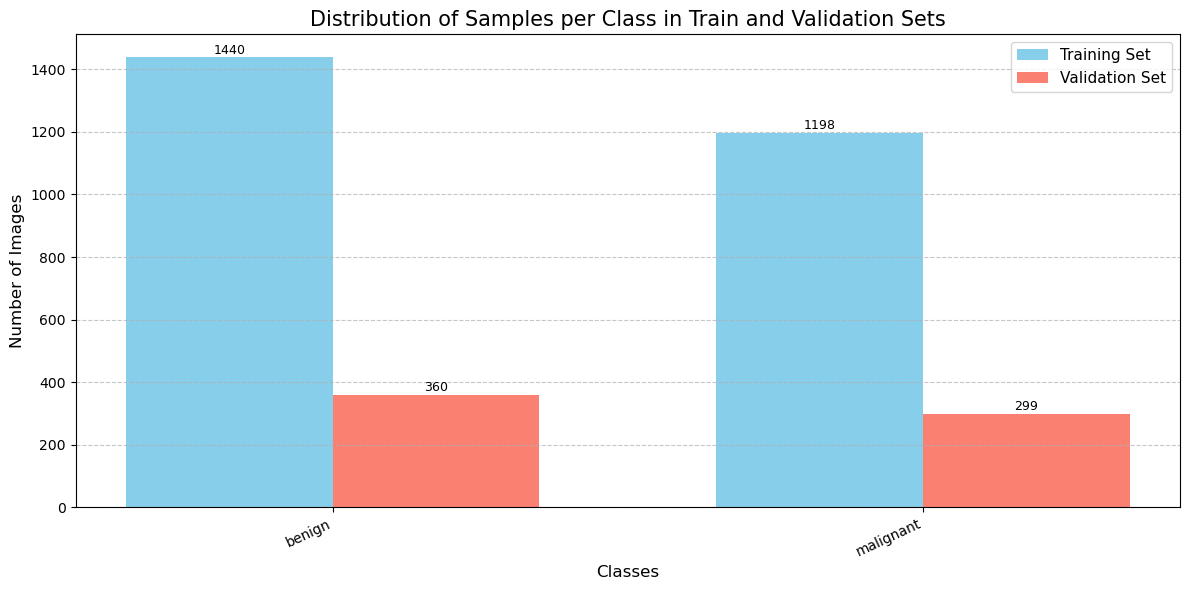

In [6]:
# Create side-by-side bar positions for each class (training and validation)
x = np.arange(len(class_names))
bar_width = 0.35

# Plotting the class distribution
fig, ax = plt.subplots(figsize=(12, 6))

train_bars = ax.bar(x - bar_width/2, train_sample_counts, width=bar_width, label='Training Set', color='skyblue')
val_bars = ax.bar(x + bar_width/2, val_sample_counts, width=bar_width, label='Validation Set', color='salmon')

# Adding value annotations on top of bars
for bar in train_bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval + 1, int(yval), ha='center', va='bottom', fontsize=9)

for bar in val_bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval + 1, int(yval), ha='center', va='bottom', fontsize=9)

# Configure plot aesthetics
ax.set_title("Distribution of Samples per Class in Train and Validation Sets", fontsize=15)
ax.set_xlabel("Classes", fontsize=12)
ax.set_ylabel("Number of Images", fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=25, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Show final plot
plt.tight_layout()
plt.show()

In [7]:
# Display the number of images per class in the training set
print("📊 Training Set Class-wise Sample Count:")
total_train = sum(train_sample_counts)
for idx, count in zip(train_class_ids, train_sample_counts):
    percentage = (count / total_train) * 100
    print(f"  - {class_names[idx]}: {count} images ({percentage:.2f}%)")

# Display the number of images per class in the validation set
print("\n📊 Validation Set Class-wise Sample Count:")
total_val = sum(val_sample_counts)
for idx, count in zip(val_class_ids, val_sample_counts):
    percentage = (count / total_val) * 100
    print(f"  - {class_names[idx]}: {count} images ({percentage:.2f}%)")

📊 Training Set Class-wise Sample Count:
  - benign: 1440 images (54.59%)
  - malignant: 1198 images (45.41%)

📊 Validation Set Class-wise Sample Count:
  - benign: 360 images (54.63%)
  - malignant: 299 images (45.37%)


In [12]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_data.num_classes, activation='softmax')  # Use softmax for multi-class classification
])


In [13]:
# Compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

In [14]:
# Print model summary
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_288 (Conv2D)         (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_289 (Conv2D)         (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_290 (Conv2D)         (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 26, 26, 128)     

In [15]:
# Callback to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_data,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_data=validation_data,
    validation_steps=validation_data.samples // validation_data.batch_size,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
82/82 [==============================] - 148s 2s/step - loss: 0.5612 - accuracy: 0.6911 - val_loss: 0.4224 - val_accuracy: 0.7937
Epoch 2/10
82/82 [==============================] - 135s 2s/step - loss: 0.4393 - accuracy: 0.7771 - val_loss: 0.3839 - val_accuracy: 0.8297
Epoch 3/10
82/82 [==============================] - 119s 1s/step - loss: 0.4218 - accuracy: 0.7909 - val_loss: 0.3844 - val_accuracy: 0.8234
Epoch 4/10
82/82 [==============================] - 129s 2s/step - loss: 0.4123 - accuracy: 0.8008 - val_loss: 0.3641 - val_accuracy: 0.8344
Epoch 5/10
82/82 [==============================] - 129s 2s/step - loss: 0.3914 - accuracy: 0.8150 - val_loss: 0.3452 - val_accuracy: 0.8297
Epoch 6/10
82/82 [==============================] - 125s 2s/step - loss: 0.3769 - accuracy: 0.8196 - val_loss: 0.3557 - val_accuracy: 0.8141
Epoch 7/10
82/82 [==============================] - 129s 2s/step - loss: 0.3781 - accuracy: 0.8216 - val_loss: 0.3339 - val_accuracy: 0.8297
Epoch 8/10
82

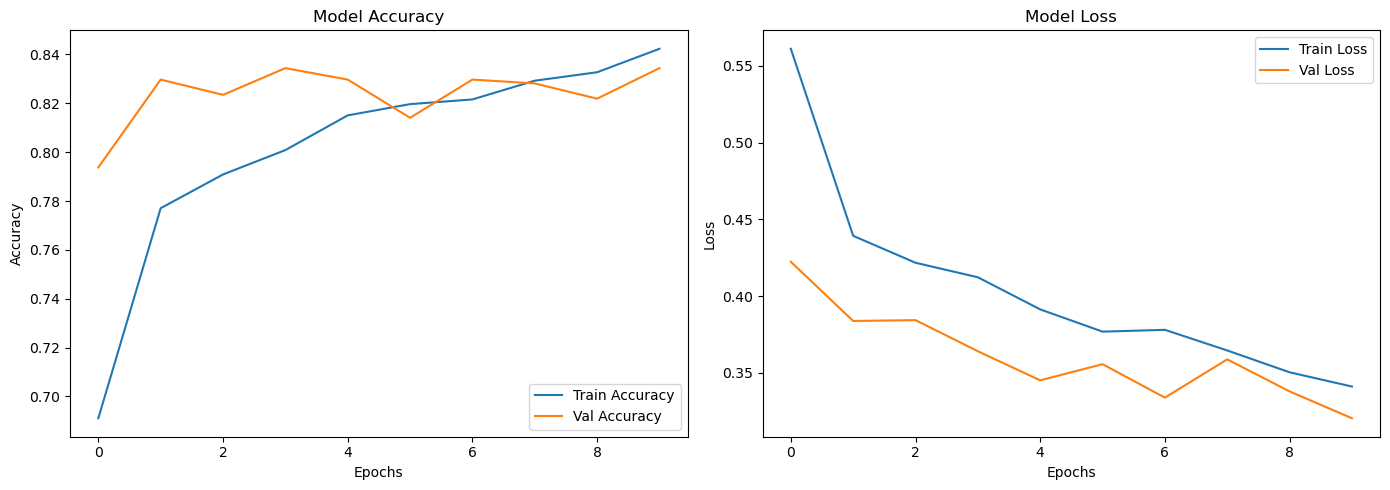

In [16]:
# Visualizing training history
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

21/21 [==============================] - 6s 284ms/step
Classification Report:
              precision    recall  f1-score   support

      benign       0.87      0.82      0.84       360
   malignant       0.80      0.85      0.82       299

    accuracy                           0.83       659
   macro avg       0.83      0.83      0.83       659
weighted avg       0.83      0.83      0.83       659



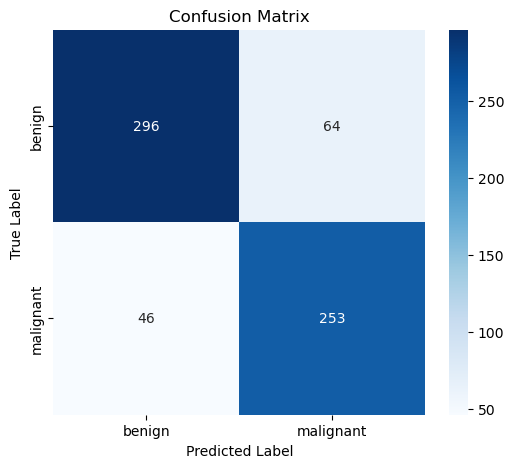

In [17]:
# Predict probabilities
val_predictions = model.predict(validation_data)
predicted_classes = np.argmax(val_predictions, axis=1)
true_classes = validation_data.classes
class_labels = list(validation_data.class_indices.keys())

# Classification Report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

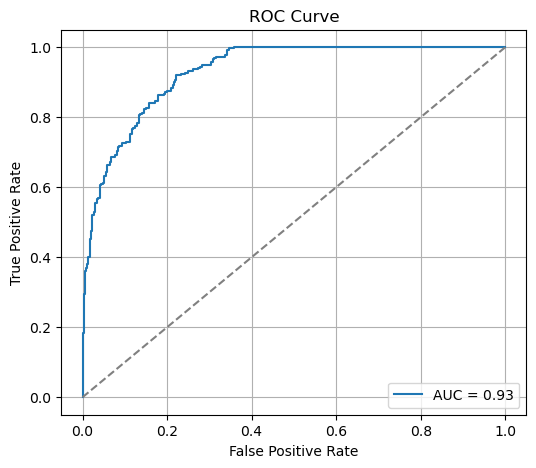

In [18]:
# Binarize true classes for ROC
y_true_binary = label_binarize(true_classes, classes=[0, 1])  # 0: benign, 1: malignant
y_pred_prob = val_predictions[:, 1]  # probability for class 1 (malignant)

fpr, tpr, thresholds = roc_curve(y_true_binary, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [31]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model layers

In [32]:
# Create new head for transfer learning
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(train_data.num_classes, activation='softmax')(x)

# Construct the complete model
transfer_model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
transfer_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Show model summary
transfer_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_291 (Conv2D)         (None, 111, 111, 32)         864       ['input_11[0][0]']            
                                                                                                  
 batch_normalization_282 (B  (None, 111, 111, 32)         96        ['conv2d_291[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_282 (Activation  (None, 111, 111, 32)         0         ['batch_normalization_28

In [34]:
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

history_transfer = transfer_model.fit(
    train_data,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_data=validation_data,
    validation_steps=validation_data.samples // validation_data.batch_size,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
82/82 [==============================] - 180s 2s/step - loss: 0.5556 - accuracy: 0.7256 - val_loss: 0.4343 - val_accuracy: 0.7953
Epoch 2/10
82/82 [==============================] - 178s 2s/step - loss: 0.4658 - accuracy: 0.7778 - val_loss: 0.4135 - val_accuracy: 0.8172
Epoch 3/10
82/82 [==============================] - 191s 2s/step - loss: 0.4209 - accuracy: 0.8066 - val_loss: 0.3985 - val_accuracy: 0.8188
Epoch 4/10
82/82 [==============================] - 195s 2s/step - loss: 0.3885 - accuracy: 0.8273 - val_loss: 0.3955 - val_accuracy: 0.8156
Epoch 5/10
82/82 [==============================] - 216s 3s/step - loss: 0.3712 - accuracy: 0.8335 - val_loss: 0.4081 - val_accuracy: 0.8062
Epoch 6/10
82/82 [==============================] - 235s 3s/step - loss: 0.3604 - accuracy: 0.8327 - val_loss: 0.3803 - val_accuracy: 0.8328
Epoch 7/10
82/82 [==============================] - 204s 2s/step - loss: 0.3350 - accuracy: 0.8588 - val_loss: 0.3789 - val_accuracy: 0.8250
Epoch 8/10
82

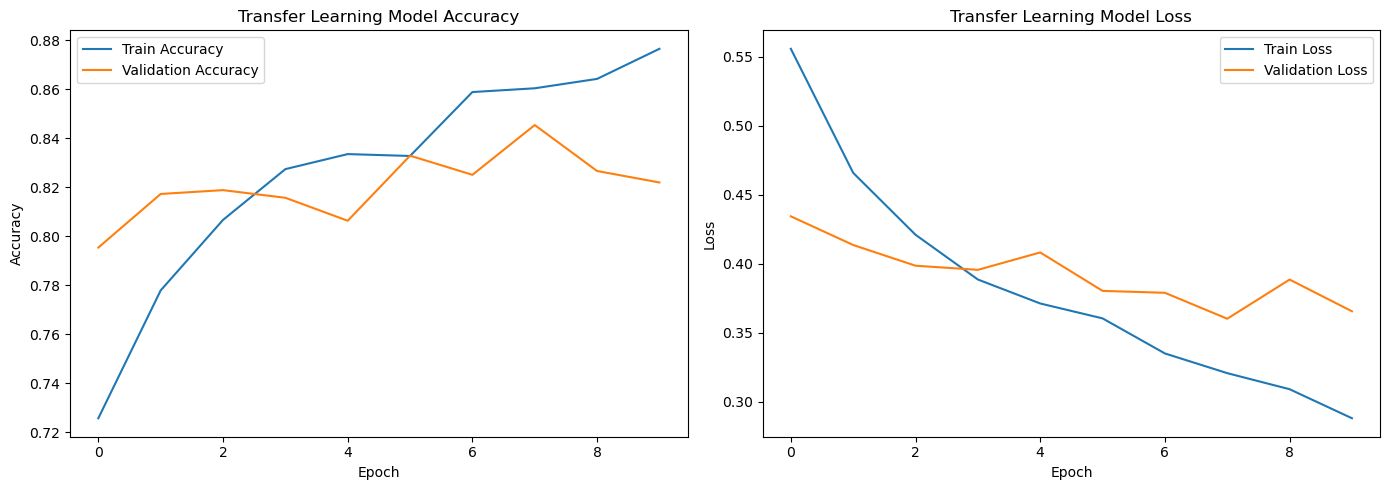

In [35]:
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_transfer.history['accuracy'], label='Train Accuracy')
plt.plot(history_transfer.history['val_accuracy'], label='Validation Accuracy')
plt.title('Transfer Learning Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_transfer.history['loss'], label='Train Loss')
plt.plot(history_transfer.history['val_loss'], label='Validation Loss')
plt.title('Transfer Learning Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

21/21 [==============================] - 35s 1s/step
              precision    recall  f1-score   support

      benign       0.86      0.80      0.83       360
   malignant       0.78      0.84      0.81       299

    accuracy                           0.82       659
   macro avg       0.82      0.82      0.82       659
weighted avg       0.82      0.82      0.82       659



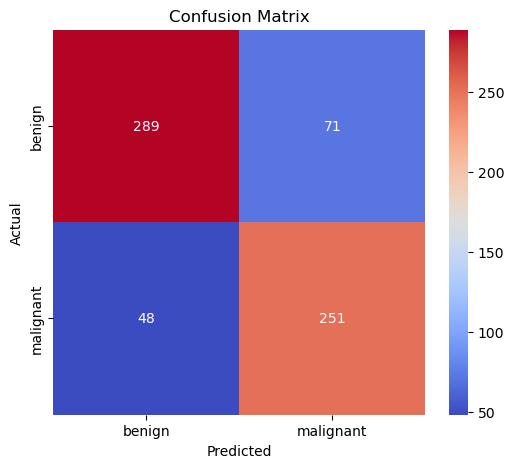

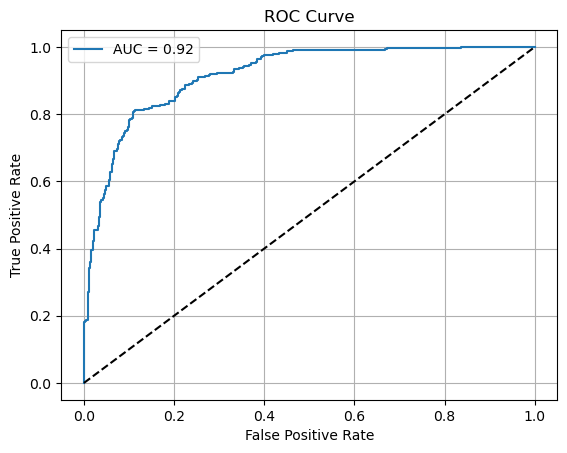

In [36]:
# Predict labels on validation set
val_probs = transfer_model.predict(validation_data)
val_preds = np.argmax(val_probs, axis=1)
true_labels = validation_data.classes
class_names = list(validation_data.class_indices.keys())

# Classification Report
print(classification_report(true_labels, val_preds, target_names=class_names))

# Confusion Matrix
conf_mat = confusion_matrix(true_labels, val_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="coolwarm", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve for Binary Classification
if len(class_names) == 2:
    from sklearn.metrics import roc_curve, auc
    binarized_true = label_binarize(true_labels, classes=[0, 1])
    fpr, tpr, _ = roc_curve(binarized_true, val_probs[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid()
    plt.show()